In [1]:
"""Scripts for analyzing of phantom outputs.

This script calculate the optical depth of the dust shell.

Author: Chunliang Mu (at Macquarie University, expected duration 2023-2026)


-------------------------------------------------------------------------------

Side note: Remember to limit line length to 79 characters according to PEP-8
    https://peps.python.org/pep-0008/#maximum-line-length    
which is the length of below line of '-' characters.

-------------------------------------------------------------------------------

"""

"Scripts for analyzing of phantom outputs.\n\nThis script calculate the optical depth of the dust shell.\n\nAuthor: Chunliang Mu (at Macquarie University, expected duration 2023-2026)\n\n\n-------------------------------------------------------------------------------\n\nSide note: Remember to limit line length to 79 characters according to PEP-8\n    https://peps.python.org/pep-0008/#maximum-line-length    \nwhich is the length of below line of '-' characters.\n\n-------------------------------------------------------------------------------\n\n"

.

# Def

.

## Imports & Settings

In [2]:
import math
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
# fix weird moviepy cannot find my ffmpeg exe error
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
#from moviepy.editor import ImageSequenceClip
#from os import path

from datetime import datetime, UTC
now_utc = lambda: datetime.now(UTC)
now = now_utc

# fix numpy v1.* compatibility
try: np.trapezoid
except AttributeError: np.trapezoid = np.trapz

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos, get_col_kernel_funcs
from clmuphantomlib.log        import is_verbose, say
#from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.io         import json_dump, json_load
from clmuphantomlib.eos        import get_eos_opacity
from clmuphantomlib.light      import get_optical_depth, get_photosphere_on_ray
#from clmuphantomlib.sph_interp import get_col_kernel_funcs

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_TauDust__input import (
    verbose,
    interm_dir, output_dir, JOB_PROFILES_DICT, job_nicknames, unitsOut, PHOTOSPHERE_TAU,
)
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting dust shell optical depth."
metadata['Description'] = f"""Getting dust shell optical depth
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 20 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_sph_gradient, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos import EoS_Base
#from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
from numpy import typing as npt
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

.

## Main

.


In [6]:
do_debug = False

In [21]:
if __name__ == '__main__' and not do_debug:

    ray = np.array((
        (0, 0, 0),
        (0, 0, 1)
    ), dtype=np.float64)

    for job_nickname in job_nicknames: #['2md', ]:
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']
        params      = job_profile['params']
        eos_opacity = get_eos_opacity(ieos=10, params=params)    #EoS_MESA_opacity(params, settings)
        
        data = {
            'times': np.full(len(file_indexes), np.nan) * units.yr,
            'tau_dust' : np.full(len(file_indexes), np.nan),
        }
            
        for ifile, file_index in enumerate(file_indexes):
            mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='CoM', verbose=1)

            # select the closer to the observer half that matters
            assert np.count_nonzero(ray) == 1 and ray[1, 2]
            sdf = mpdf.data['gas'].loc[mpdf.data['gas']['z'] > 0].copy()
            
            sdf['kappa'] = sdf['kappa_dust']

            pts_on_ray, dtaus, pts_order = get_optical_depth(sdf, ray)

            tau_dust = np.sum(dtaus)
            if is_verbose(verbose, 'info'):
                say('info', None, verbose, f"{job_nickname}_{file_index:05d}: {tau_dust = :7.3f}")

            data['times'][ifile] = mpdf.get_time()
            data['tau_dust'][ifile] = tau_dust

            del pts_on_ray, dtaus, pts_order, tau_dust

        # save data
        outfilename = f"{interm_dir}taudust.{job_nickname}.json"
        with open(outfilename, 'w') as f:
            mupl.json_dump(data, f, metadata)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Saved to '{outfilename}'.")

    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00000: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00020: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00040: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00060: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00080: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00100: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00120: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00140: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00160: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>():
	2md_00180: tau_dust =   0.000
    Debug  :    run_ast_nodes() ==> run_code() ==> <module>(

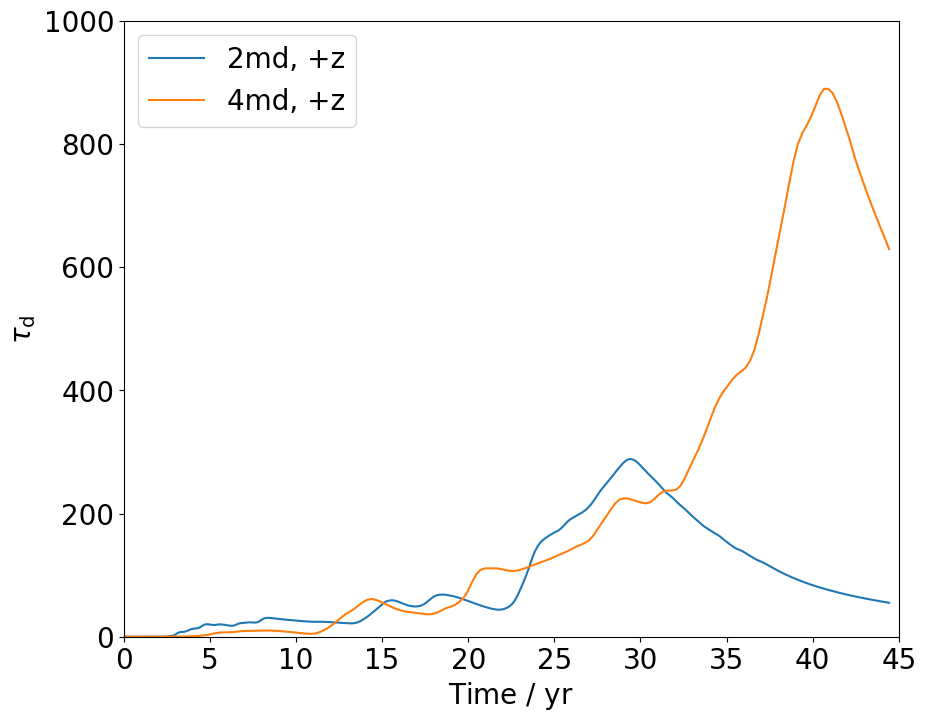

In [24]:
if __name__ == '__main__' and not do_debug:
    
    fig, ax = plt.subplots(figsize=(10, 8))

    for job_nickname in job_nicknames:
        with open(f"{interm_dir}taudust.{job_nickname}.json", 'r') as f:
            data = mupl.json_load(f, metadata)
        mask = np.isfinite(data['times'])
        xs = data['times'][mask]
        ys = data['tau_dust'][mask]
        ax.plot(xs, ys, label=f"{job_nickname}, +z")

    ax.set_xlim((0,  45))
    ax.set_ylim((0, 400))
    ax.set_xlabel(f"Time / {xs.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$\\tau_\\mathrm{{d}}$")
    ax.legend()

    fig.savefig(f"{output_dir}taudust.pdf")

    ax.set_ylim((0, 1000))
    fig.savefig(f"{output_dir}taudust-more.pdf")
    